In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


In [3]:
import pandas
import cv2
import numpy
import tensorflow

In [4]:
# data = pandas.read_csv("/Users/akshitshishodia/intern/labels_my-project-name_2023-06-27-09-45-54.csv")
# data

In [5]:
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam


In [11]:
class Tracker():
    
    H = 512
    W = 512
    
    def __init__(self):
        pass
    
    @staticmethod
    def build_model(input_shape):
        input = layers.Input(input_shape)

        pre_trained = MobileNetV2(
            include_top = False,
            weights = "imagenet",
            input_tensor = input,
            alpha = 1.0
        )
        pre_trained.trainable = False
        x = pre_trained.output
        x = layers.Conv2D(256, kernel_size=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(4, activation="sigmoid")(x)

        model = Model(input,x)
        return model

    
    def load_dataset(split = 0.2):
        data = pandas.read_csv('labels_my-project-name_2023-06-27-09-45-54.csv')
        path  = '/Users/akshitshishodia/intern/tracker/dataset/'
        image = list()
        bounding_box = list()

        for idx,rows in data.iterrows():
            name = path + str(rows['image_name'])
            bbox = [rows['bbox_x'],rows['bbox_y'],rows['bbox_width'],rows['bbox_height']]
            image.append(name)
            bounding_box.append(bbox)
        
        sample_size = int(len(image)*0.2)
        
        train_x, valid_x = train_test_split(image,test_size=sample_size,random_state=42)
        train_y, valid_y = train_test_split(bounding_box,test_size=sample_size,random_state=42)

        train_x, test_x = train_test_split(train_x,test_size=sample_size,random_state=42)
        train_y, test_y = train_test_split(train_y, test_size=sample_size, random_state=42)

        return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

    @classmethod
    def read_image(cls,path,bbox):
        path = path.decode()
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        height,width,_ = img.shape
        img = cv2.resize(img,(cls.W,cls.H))
        img = (img-127.5)/127.5
        img = img.astype(numpy.float32)

        x,y,w,h = bbox
        x_c = x+w
        y_c = y+h

        norm_x = float(x/width)
        norm_y = float(y/height)
        norm_xc = float(x_c/width)
        norm_yc = float(y_c/height)
        
        normalised = numpy.array([norm_x,norm_y,norm_xc,norm_yc],dtype = numpy.float32)

        return img, normalised
    
    @classmethod 
    def parse(cls,x,y):
        x,y = tensorflow.numpy_function(cls.read_image,[x,y],[tensorflow.float32,tensorflow.float32])
        x.set_shape([cls.H,cls.W,3])
        y.set_shape([4])
        return x,y
    
    @classmethod 
    def tensor_dataset(cls,image,b_box,batch=8):
        ds = tensorflow.data.Dataset.from_tensor_slices((image,b_box))
        ds = ds.map(cls.parse).batch(batch).prefetch(10)
        return ds

    def run(self):
        numpy.random.seed(42)
        tensorflow.random.set_seed(42)

        batch_size = 16
        lr = 1e-4
        epochs = 500

        (train_x,train_y),(valid_x,valid_y),(test_x,test_y) = self.load_dataset()
        training_dataset = self.tensor_dataset(train_x,train_y,batch = batch_size)

        validation_dataset = self.tensor_dataset(valid_x,valid_y,batch = batch_size)

        model = self.build_model((self.H,self.W,3))

        model.compile(
            loss = 'binary_crossentropy',
            optimizer = Adam(lr)
        )

        model_path = os.path.join('files','model_2.h5')
        csv_path = os.path.join('files','log_2.csv')

        callbacks = [
            ModelCheckpoint(model_path,verbose =1,save_best = True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
            CSVLogger(csv_path, append=True),
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
   
        ]

        history = model.fit(
            training_dataset,
            epochs = epochs,
            validation_data = validation_dataset,
            callbacks = callbacks
        )
        return history





In [12]:
tracker_obj = Tracker()
history = tracker_obj.run()


Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: 0.6942
Epoch 1: saving model to files/model_2.h5
6/6 [==============================] - 7s 947ms/step - loss: 0.6942 - val_loss: 0.6730 - lr: 1.0000e-04
Epoch 2/500


/Users/akshitshishodia/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - ETA: 0s - loss: 0.6757
Epoch 2: saving model to files/model_2.h5
6/6 [==============================] - 6s 962ms/step - loss: 0.6757 - val_loss: 0.6627 - lr: 1.0000e-04
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: 0.6689
Epoch 3: saving model to files/model_2.h5
6/6 [==============================] - 6s 972ms/step - loss: 0.6689 - val_loss: 0.6570 - lr: 1.0000e-04
Epoch 4/500
6/6 [==============================] - ETA: 0s - loss: 0.6652
Epoch 4: saving model to files/model_2.h5
6/6 [==============================] - 5s 887ms/step - loss: 0.6652 - val_loss: 0.6552 - lr: 1.0000e-04
Epoch 5/500
6/6 [==============================] - ETA: 0s - loss: 0.6653
Epoch 5: saving model to files/model_2.h5
6/6 [==============================] - 5s 816ms/step - loss: 0.6653 - val_loss: 0.6553 - lr: 1.0000e-04
Epoch 6/500
6/6 [==============================] - ETA: 0s - loss: 0.6615
Epoch 6: saving model to files/model_2.h5
6/6 [===========

KeyError: "None of [Index(['binary_accuracy', 'val_binary_accuracy'], dtype='object')] are in the [columns]"

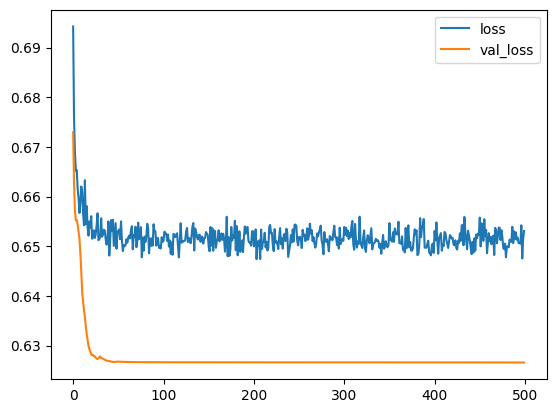

In [13]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [97]:

# H = 512
# W = 512
# def build_model(input_shape):
#     input = layers.Input(input_shape)
#     pre_trained = MobileNetV2(
#         include_top = False,
#         weights = "imagenet",
#         input_tensor = input,
#         alpha = 1.0
#     )
#     pre_trained.trainable = False
#     x = pre_trained.output
#     x = layers.Conv2D(256, kernel_size=1, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(4, activation="sigmoid")(x)
#     model = Model(input,x)
#     return model
# def load_dataset(split = 0.2):
#     data = pandas.read_csv('labels_my-project-name_2023-06-27-09-45-54.csv')
#     path  = '/Users/akshitshishodia/intern/tracker/dataset/'
#     image = list()
#     bounding_box = list()
#     for idx,rows in data.iterrows():
#         name = path + str(rows['image_name'])
#         bbox = [rows['bbox_x'],rows['bbox_y'],rows['bbox_width'],rows['bbox_height']]
#         image.append(name)
#         bounding_box.append(bbox)  
#     sample_size = int(len(image)*0.2)
#     train_x, valid_x = train_test_split(image,test_size=sample_size,random_state=42)
#     train_y, valid_y = train_test_split(bounding_box,test_size=sample_size,random_state=42)
#     train_x, test_x = train_test_split(train_x,test_size=sample_size,random_state=42)
#     train_y, test_y = train_test_split(train_y, test_size=sample_size, random_state=42)
#     return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
# def read_image(path,bbox):
#     path = path.decode()
#     img = cv2.imread(path)
#     height,width,_ = img.shape
#     img = cv2.resize(img,(W,H))
#     img = (img-127.5)/127.5
#     img = img.astype(numpy.float32)
#     x,y,w,h = bbox
#     x_c = x+w
#     y_c = y+h
#     norm_x = float(x/width)
#     norm_y = float(y/height)
#     norm_xc = float(x_c/width)
#     norm_yc = float(y_c/height)    
#     normalised = numpy.array([norm_x,norm_y,norm_xc,norm_yc],dtype = numpy.float32)
#     return img, normalised
# def parse(x,y):
#     x,y = tensorflow.numpy_function(read_image,[x,y],[tensorflow.float32,tensorflow.float32])
#     x.set_shape([H,W,3])
#     y.set_shape([4])
#     return x,y
# def tensor_dataset(image,b_box,batch=8):
#     ds = tensorflow.data.Dataset.from_tensor_slices((image,b_box))
#     ds = ds.map(parse).batch(batch).prefetch(10)
#     return ds
# def run():
#     numpy.random.seed(42)
#     tensorflow.random.set_seed(42)
#     batch_size = 16
#     lr = 1e-4
#     epochs = 500
#     (train_x,train_y),(valid_x,valid_y),(test_x,test_y) = load_dataset()
#     training_dataset = tensor_dataset(train_x,train_y,batch = batch_size)
#     validation_dataset = tensor_dataset(valid_x,valid_y,batch = batch_size)
#     model = build_model((H,W,3))
#     model.compile(
#         loss = 'binary_crossentropy',
#         optimizer = Adam(lr)
#     )
#     model_path = os.path.join('files','model.h5')
#     csv_path = os.path.join('files','log.csv')
#     callbacks = [
#         ModelCheckpoint(model_path,verbose =1,save_best = True),
#         ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
#         CSVLogger(csv_path, append=True),
#         EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
#     ]
#     model.fit(
#         training_dataset,
#         epochs = epochs,
#         validation_data = validation_dataset,
#         callbacks = callbacks
#     )




In [85]:
(train_x,train_y),(valid_x,valid_y),(test_x,test_y) = load_dataset()
training_dataset = tensor_dataset(train_x,train_y,batch = 8)

In [98]:
run()


Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: 0.7693
Epoch 1: saving model to files/model.h5
6/6 [==============================] - 7s 937ms/step - loss: 0.7693 - val_loss: 0.7154 - lr: 1.0000e-04
Epoch 2/500


/Users/akshitshishodia/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - ETA: 0s - loss: 0.7399
Epoch 2: saving model to files/model.h5
6/6 [==============================] - 5s 908ms/step - loss: 0.7399 - val_loss: 0.6997 - lr: 1.0000e-04
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: 0.7196
Epoch 3: saving model to files/model.h5
6/6 [==============================] - 5s 812ms/step - loss: 0.7196 - val_loss: 0.6904 - lr: 1.0000e-04
Epoch 4/500
6/6 [==============================] - ETA: 0s - loss: 0.7003
Epoch 4: saving model to files/model.h5
6/6 [==============================] - 5s 824ms/step - loss: 0.7003 - val_loss: 0.6822 - lr: 1.0000e-04
Epoch 5/500
6/6 [==============================] - ETA: 0s - loss: 0.6900
Epoch 5: saving model to files/model.h5
6/6 [==============================] - 5s 808ms/step - loss: 0.6900 - val_loss: 0.6752 - lr: 1.0000e-04
Epoch 6/500
6/6 [==============================] - ETA: 0s - loss: 0.6801
Epoch 6: saving model to files/model.h5
6/6 [=====================